>## how do i know which of my models has done the best?

>## experimenet tracking.
1. python dict
2. weights and biases
3. tensorboard (here)
4. mlflow

In [1]:
import torch
import torchvision
from torchvision import transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
set_seeds()

## get data

In [5]:
import os
import zipfile


from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """downlaodes a zipped dataset from sourec and unzips to destination

    Args:
        source (str): link
        detination (str): dir of dataset
        remove_source (bool, optional): remove zip file. Defaults to True.

    Returns:
        Path: return dir path
    """
    data_path = Path('data')
    image_path = data_path / destination
    
    #if the iamge folder doesn't exist, create it 
    if image_path.is_dir():
        print(f"[INFO] {image_path} dire already exists, skipping downoload.")
    else:
        print(f"[INFO] did not find {image_path} dir, creating one")
        image_path.mkdir(parents=True, exist_ok=True)
        #download the data
        target_file = Path(source).name
        with open(data_path/target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] downloading {target_file} from {source}")
            f.write(request.content)
            
        #unzip target file
        with zipfile.ZipFile(data_path/ target_file, "r") as zip_ref:
            print(f"[INFO] unzipping {target_file} data...")
            zip_ref.extractall(image_path)
            
        #remove the .zip flie if needed
        if remove_source:
            os.remove(data_path/ target_file)
            
    return image_path

In [6]:
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                           destination='pizza_steak_sushi')
image_path


[INFO] data/pizza_steak_sushi dire already exists, skipping downoload.


PosixPath('data/pizza_steak_sushi')

# creating dataloaders 

## using manual transforms option 1:

In [7]:
#setup the directories
train_dir = image_path / "train"
test_dir = image_path / "test"


In [8]:
#setup imagenet normalization levels
import os 
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

#create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])
print(f"manually created transforms: {manual_transforms}")

#create dataloaders
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32,
    num_workers=os.cpu_count()
)
train_dataloader, test_dataloader, class_names

manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7efcdd367f90>,
 ['pizza', 'steak', 'sushi'])

## creating transforms automatically  option 2

In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"

#setup pretrained wights (plenty of these waits are availbale in torchvision.models module)
import torchvision
#automatically created transforms 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #best weights =  DEFAULT
#transformed used to obtain a particular set of weights
automatic_transforms = weights.transforms() 
print(f"automatically created transforms: {automatic_transforms}")
#create data 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32,
    num_workers=os.cpu_count()
)
train_dataloader, test_dataloader, class_names

automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7efcdd37dc90>,
 ['pizza', 'steak', 'sushi'])

## getting a pretrained model and freezing its base layers and modifying its classifier head

## old method option 1:

In [10]:
model = torchvision.models.efficientnet_b0(pretrained=True).to(device) #OLD

/home/stanley/Documents/shidder/ml/pytorching/9_pytorch_experiment_tracking/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stanley/Documents/shidder/ml/pytorching/9_pytorch_experiment_tracking/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## new method option 2:

In [11]:
#download the pretrained weights for effnetb0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #DEFAULT is best available weights

#setup the model with pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [13]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
#freez the base layers/ feature extractors by setting the req grad attributes to false
for param in model.features.parameters():
    param.requires_grad = False


In [16]:
from torch import nn
#change the classifier head ie the output layer to fit our problem
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)


In [17]:
from torchinfo import summary
summary(model=model,
        input_size=[32,3,224,224],
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## train a single model  and track results - `single experiment`

In [18]:
#define loss function and an optimizer function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [19]:
#setup a summary writer
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

## to track our experiments we are gonna use tensorboards summary writer

In [20]:
from going_modular.going_modular.engine import train_step, test_step
#we are gonna modify the train() from engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ###new: Experiment tracking
        #see summarywriter doc
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                                            global_step=epoch)
        writer.add_scalars(main_tag='Accuracy',
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32,3,224,224).to(device))
    #close the writer 
    writer.close()
    ### END NEW ###
    
    # Return the filled results at the end of the epochs
    return results


## not using engine.train() since we updated the train() function above

In [21]:
#train model
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3906 | test_loss: 0.9144 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.9047 | train_acc: 0.6445 | test_loss: 0.7882 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.8096 | train_acc: 0.7305 | test_loss: 0.6768 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6848 | train_acc: 0.8633 | test_loss: 0.6739 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7080 | train_acc: 0.7266 | test_loss: 0.6793 | test_acc: 0.7737


>## view our models results with tensorboard

In [22]:
#lets view our experiments from within the notebook
#there are multiple ways to view tensorboard results
%load_ext tensorboard
%tensorboard --logdir runs

In [23]:
!kill 64414

zsh:kill:1: kill 64414 failed: no such process


## by default `summaryWriter()` cass saves to log`log_dir`
how about if we watned to save diffrent experiments to diffrent folders?

in essence one experiment = one folder

### for example we'd liek t track
- experiment data/timestamp
- experiment name
- model name
- extra = is there anything else that shouldbe tracked?

## lets create a  function `SummaryWriter()` instance to take ll of these into account.
so ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [24]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name:str ,
                  model_name: str,
                  extra: str = None):
    """creates a torch.utils.tensorboard.writer.SummaryWrtier() insace trakcing to a specific directory"""
    from datetime import datetime
    import os
    
    #Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%y-%m-%d")
    
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"[INFO] created summarywrtier saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [25]:
from datetime import datetime

time_now = datetime.now().date()
datetime.now().date()
datetime.now().strftime("%y-%m-%d")


'23-09-30'

In [26]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] created summarywrtier saving to runs/23-09-30/data_10_percent/effnetb0/5_epochs


In [27]:
%reload_ext tensorboard

In [28]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3047), started 0:00:01 ago. (Use '!kill 3047' to kill it.)

## create a function to prepare a `SummaryWriter()` instance
by default our `summarywritter saves to log_drhow 
how about if we wanted to save fiferent experiemnts to dfferent folders
In essence one experiemnet = one folder.
For example, we'd like to track:
- Experiemnt data/timestamp
- experiment name
- model name
- extra - is there anything else that should be tracked

lets create  a `summarywriter()` insace to take all of these things into account so ideally we end up trakcing experiments to a directory 

runs/YYY-Mm_DD/ experiement_name/model_name/extra

In [40]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
    """craetes a torch.utils.tensorboard.writer.summaryWriter() insace tracking to a specific experiment"""
    
    from datetime import datetime
    import os
    
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        #create log_dir path
        log_dir = os.path.join("runs",timestamp, experiment_name, model_name, extra)    
    else:
        log_dir = os.path.join("runs",timestamp, experiment_name, model_name, extra)
    print(f"[INFO] created SummaryWriter to {log_dir}")
    
    return SummaryWriter(log_dir=log_dir)
    

In [41]:
timestamp = datetime.now().strftime("%Y-%m-%d")
timestamp

'2023-09-30'

In [42]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="eff_net_b0",
                               extra="5_epochs")
example_writer

[INFO] created SummaryWriter to runs/2023-09-30/data_10_percent/eff_net_b0/5_epochs


## update the train() to be able to use the createwriter() 


In [67]:
from going_modular.going_modular.engine import train_step, test_step
#we are gonna modify the train() from engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ###new: Experiment tracking
        #see summarywriter doc
        if writer:
            writer.add_scalars(main_tag="Loss",
                                tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                                                global_step=epoch)
            writer.add_scalars(main_tag='Accuracy',
                                tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                                global_step=epoch)
            writer.add_graph(model=model,
                                input_to_model=torch.randn(32,3,224,224).to(device))
            #close the writer 
            writer.close()
        else:
            pass
    ### END NEW ###
    
    # Return the filled results at the end of the epochs
    return results


## 7. setting up a series of modelling experiments 
- setupp 2x modelling experiemnts with effenetb-, pizza, steakz sushi data and train one model for `5 epochs` and another model fo `10 epochs`

## 7.1 what kind of experiments should u learn
the number of machine learnign experiemnts you can run , is liek thenumber of differnet models you can build.... almost limitless.

however, you can't etst evrthing...

### so what should u test?
- change the number of epochs
- change the number of hidden layers/units
- change the amount of data
- change learning rate
- try diffrent kinds of data augmentation
- choose a diffrent model architecture

**all of these** 
this is why transfer learning is so powerful, because its a working model that you can apply to your own problem

### experiments that **we** are gonna try
we are going to turn 3 dials
1. model size - effnetb0(smallest) effnetb2(larger)
2. dataset size - 10% dataset vs 20% dataset
3. training time - 5 vs 10 eochs

-> to begin we're still keeping things relatively small so that our experiments run quickly 

### our goal : a model that is well performing but still small enought to run on a mobile device or web browser 
if you had infinite compute and time you should basiclaly always chosoe the biggest modela dn biggest dataset you can 

## we want 2 datasets:

1. pizza steak, sushi 10%
2. pizza, steak, sushi 20%

In [43]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi",
                                     remove_source=True)
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent",
                                     remove_source=True)

[INFO] data/pizza_steak_sushi dire already exists, skipping downoload.
[INFO] did not find data/pizza_steak_sushi_20_percent dir, creating one
[INFO] downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip
[INFO] unzipping pizza_steak_sushi_20_percent.zip data...


## creating dataloaders
we'll hvae to transform our data in a nfew ways:
1. Resize the iamges to (224,224)
2. makesure the iamge teensor values are between [0,1]
3. normailze the iage sto they have the same data distribution as ImageNet


In [46]:
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent= data_20_percent_path / "train"

#testdir 
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [47]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

simple_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

## using data_setup.py script to create dataloaders

In [48]:
BATCH_SIZE = 32
import os
#crete 10per cent traning and test dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          batch_size=BATCH_SIZE,
                                                                                          num_workers=os.cpu_count()
                                                                                          )

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          batch_size=BATCH_SIZE,
                                                                                          num_workers=os.cpu_count()
                                                                                          )

print(f"Number of batches of sze {BATCH_SIZE} in 10% train_data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of sze {BATCH_SIZE} in 20% train_data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of sze {BATCH_SIZE} in 10% test_data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of sze 32 in 10% train_data: 8
Number of batches of sze 32 in 20% train_data: 15
Number of batches of sze 32 in 10% test_data: 3
Class names: ['pizza', 'steak', 'sushi']


## crteat feature extractor models
we watn 2 functions:
1. creates a `torchvision.models.efficient_net_b0()` feature extractor with the base layers/ back bone and a custom classifier head
2. creates a `torchvision.models.efficient_net_b2()` feature extractor with the base layers/ back bone and a custom classifier head

In [49]:
import torchvision

#cretae an effnetb0
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT #default = best available 
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
effnetb2



Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /home/stanley/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:19<00:00, 1.92MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [50]:
from torchinfo import summary
summary(model=effnetb2,
        input_size=[32,3,224,224],
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## creating the 2 functions

In [52]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)
#cretea an effnetb0 feature extractor
def create_effnetb0():
    #get weifghta s setup a model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    #freez ehte base layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    #give the model the name
    model.name = "effnetb0"
    print(f"[INFO] created new {model.name} model...")
    
    return model

In [53]:
create_model_test = create_effnetb0()


[INFO] created new effnetb0 model...


In [54]:
from torchinfo import summary
summary(model=create_model_test,
        input_size=[32,3,224,224],
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [55]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [56]:
def create_effnetb2():
    #get weifghta s setup a model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    #freez ehte base layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES) #need to change the in_features to the classfier layer input sahpe from original
    ).to(device)
    
    #give the model the name
    model.name = "effnetb2"
    print(f"[INFO] created new {model.name} model...")
    
    return model

In [57]:
create_model_test = create_effnetb2()

[INFO] created new effnetb2 model...


In [58]:
from torchinfo import summary
summary(model=create_model_test,
        input_size=[32,3,224,224],
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [60]:
create_model_test_effnetb0 = create_effnetb0()
create_model_test_effnetb2 = create_effnetb2()

[INFO] created new effnetb0 model...
[INFO] created new effnetb2 model...


In [62]:
from torchinfo import summary
summary(model=create_model_test_effnetb0,
        input_size=[32,3,224,224],
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [63]:
from torchinfo import summary
summary(model=create_model_test_effnetb2,
        input_size=[32,3,224,224],
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## create experiments and setup training code

In [64]:
#create epoch list
num_epochs = [5,10]

#create models list (need to create a new model for each experimeent)
models = ["effnetb0", "effnetb2"]

#create a dataloaders dict
train_dataloaders = {"data_10_percent_path": train_dataloader_10_percent,
                     "data_20_percent_path": train_dataloader_20_percent}

In [65]:
train_dataloaders.items()

dict_items([('data_10_percent_path', <torch.utils.data.dataloader.DataLoader object at 0x7efcd0c8f250>), ('data_20_percent_path', <torch.utils.data.dataloader.DataLoader object at 0x7efcd2e47090>)])

In [69]:
%%time
from going_modular.going_modular import utils
#set the seeds
set_seeds(seed=42)

#keep track of experiment numbers
experiment_number = 0 

#loop thourgh eaxh dataloader
for dataloader_name, train_dataloader in train_dataloaders.items():
    #loop thourgh the epochs
    for epochs in num_epochs:
        #loop thourhg each model and createa new model instance
        for model_name in models:
            #print outinfo
            experiment_number += 1
            print(f"[INFO] experiment no: {experiment_number}")
            print(f"[INFO] epochs: {epochs}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Model: {model_name}")
            
            #select and ceat th model
            
            if model_name == 'effnetb0':
                model = create_effnetb0()
            else:
                model = create_effnetb2()
                
            #cretea a new loss and optiimizer for every model:
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(),
                                         lr = 0.001)
            
            #train the target model with target datalodaer and track experiments
            #USING TRAIN() RATHER THAN ENGINE.TRAIN()
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  device=device,
                  epochs=epochs,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            #save the model  to the file so we can import if need be
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            utils.save_model(model=model,
                             target_dir="models",
                             model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] experiment no: 1
[INFO] epochs: 5
[INFO] DataLoader: data_10_percent_path
[INFO] Model: effnetb0
[INFO] created new effnetb0 model...
[INFO] created SummaryWriter to runs/2023-09-30/data_10_percent_path/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0426 | train_acc: 0.5039 | test_loss: 0.9255 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9399 | train_acc: 0.5352 | test_loss: 0.8308 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8171 | train_acc: 0.7070 | test_loss: 0.7255 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7087 | train_acc: 0.7617 | test_loss: 0.6175 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6154 | train_acc: 0.8945 | test_loss: 0.5824 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_path_5_epochs.pth
--------------------------------------------------

[INFO] experiment no: 2
[INFO] epochs: 5
[INFO] DataLoader: data_10_percent_path
[INFO] Model: effnetb2
[INFO] created new effnetb2 model...
[INFO] created SummaryWriter to runs/2023-09-30/data_10_percent_path/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0943 | train_acc: 0.3711 | test_loss: 0.9515 | test_acc: 0.7017
Epoch: 2 | train_loss: 0.8870 | train_acc: 0.6562 | test_loss: 0.8946 | test_acc: 0.6922
Epoch: 3 | train_loss: 0.8375 | train_acc: 0.6758 | test_loss: 0.7896 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.6956 | train_acc: 0.8594 | test_loss: 0.6772 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7096 | train_acc: 0.7227 | test_loss: 0.6377 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb2_data_10_percent_path_5_epochs.pth
--------------------------------------------------

[INFO] experiment no: 3
[INFO] epochs: 10
[INFO] DataLoader: data_10_percent_path
[INFO] Model: effnetb0
[INFO] created new effnetb0 model...
[INFO] created SummaryWriter to runs/2023-09-30/data_10_percent_path/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0426 | train_acc: 0.5039 | test_loss: 0.9255 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9399 | train_acc: 0.5352 | test_loss: 0.8308 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8171 | train_acc: 0.7070 | test_loss: 0.7255 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7087 | train_acc: 0.7617 | test_loss: 0.6175 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6154 | train_acc: 0.8945 | test_loss: 0.5824 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5428 | train_acc: 0.8672 | test_loss: 0.5948 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.6415 | train_acc: 0.7227 | test_loss: 0.5921 | test_acc: 0.8153
Epoch: 8 | train_loss: 0.5093 | train_acc: 0.8047 | test_loss: 0.5356 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4680 | train_acc: 0.9180 | test_loss: 0.5290 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.5725 | train_acc: 0.7461 | test_loss: 0.4855 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb0_data_10_percent_path_10_epochs.pth
-------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0943 | train_acc: 0.3711 | test_loss: 0.9515 | test_acc: 0.7017
Epoch: 2 | train_loss: 0.8870 | train_acc: 0.6562 | test_loss: 0.8946 | test_acc: 0.6922
Epoch: 3 | train_loss: 0.8375 | train_acc: 0.6758 | test_loss: 0.7896 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.6956 | train_acc: 0.8594 | test_loss: 0.6772 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7096 | train_acc: 0.7227 | test_loss: 0.6377 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5820 | train_acc: 0.8906 | test_loss: 0.6490 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.5962 | train_acc: 0.8242 | test_loss: 0.5929 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5334 | train_acc: 0.8203 | test_loss: 0.5883 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.4913 | train_acc: 0.8203 | test_loss: 0.5447 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.5076 | train_acc: 0.8086 | test_loss: 0.5337 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_10_percent_path_10_epochs.pth
-------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9664 | train_acc: 0.6271 | test_loss: 0.6670 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.6942 | train_acc: 0.7937 | test_loss: 0.5801 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5809 | train_acc: 0.8313 | test_loss: 0.5029 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4568 | train_acc: 0.8875 | test_loss: 0.4160 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4533 | train_acc: 0.8562 | test_loss: 0.3809 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_path_5_epochs.pth
--------------------------------------------------

[INFO] experiment no: 6
[INFO] epochs: 5
[INFO] DataLoader: data_20_percent_path
[INFO] Model: effnetb2
[INFO] created new effnetb2 model...
[INFO] created SummaryWriter to runs/2023-09-30/data_20_percent_path/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9740 | train_acc: 0.5542 | test_loss: 0.7713 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.6976 | train_acc: 0.7937 | test_loss: 0.6481 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5609 | train_acc: 0.8917 | test_loss: 0.5443 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5066 | train_acc: 0.8521 | test_loss: 0.5046 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4637 | train_acc: 0.8625 | test_loss: 0.4403 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_path_5_epochs.pth
--------------------------------------------------

[INFO] experiment no: 7
[INFO] epochs: 10
[INFO] DataLoader: data_20_percent_path
[INFO] Model: effnetb0
[INFO] created new effnetb0 model...
[INFO] created SummaryWriter to runs/2023-09-30/data_20_percent_path/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9664 | train_acc: 0.6271 | test_loss: 0.6670 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.6942 | train_acc: 0.7937 | test_loss: 0.5801 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5809 | train_acc: 0.8313 | test_loss: 0.5029 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4568 | train_acc: 0.8875 | test_loss: 0.4160 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4533 | train_acc: 0.8562 | test_loss: 0.3809 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4178 | train_acc: 0.8562 | test_loss: 0.3729 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.4012 | train_acc: 0.8625 | test_loss: 0.3374 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3426 | train_acc: 0.8958 | test_loss: 0.3475 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3693 | train_acc: 0.8938 | test_loss: 0.3429 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8958 | test_loss: 0.2837 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_path_10_epochs.pth
-------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9740 | train_acc: 0.5542 | test_loss: 0.7713 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.6976 | train_acc: 0.7937 | test_loss: 0.6481 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5609 | train_acc: 0.8917 | test_loss: 0.5443 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5066 | train_acc: 0.8521 | test_loss: 0.5046 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4637 | train_acc: 0.8625 | test_loss: 0.4403 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3704 | train_acc: 0.9125 | test_loss: 0.4566 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3429 | train_acc: 0.9375 | test_loss: 0.4118 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3237 | train_acc: 0.8979 | test_loss: 0.4081 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3322 | train_acc: 0.9042 | test_loss: 0.4316 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3588 | train_acc: 0.8708 | test_loss: 0.3695 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_path_10_epochs.pth
-------------------------------

## view the experiments in tensorboard
lets visualize

In [70]:
#lets view our experiments within tensor fro within thebotebook 
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 3047), started 3:21:59 ago. (Use '!kill 3047' to kill it.)

## the best performing model was
- model: EffNetB2
- Dataset: pizza, steak sushi 20%
- Epochs: 10

## uploading tensorboard to tensorboard.dev to make public
tensorboard dev upload --logdir logs \
    --name "(optional) My latest experiment \
    --description "(optional) Simple comparison of several hyperparameters" 

In [ ]:
!tensorboard dev upload --logdir runs \
    --name "exp tracking test results:1" \
    --description "comparing results of different model size, trainign data amount and trianing time" 

## you can view the experiments publically at tensorboard.dev: 
>## https://tensorboard.dev/experiment/gept3f9PTO63ADCw0nF15A/

## loading the best model and making some predictions with it
best model filepath: `models/07_effnetb2_data_20_percent_path_10_epochs.pth`

In [72]:
best_model_path = "models/07_effnetb2_data_20_percent_path_10_epochs.pth"

#instantiaate a new instance of effentb2 (to load in the saved stte_dict)

best_model = create_effnetb2()
#load the saved best model state dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] created new effnetb2 model...


<All keys matched successfully>

## our goal is to create a model that performs well enough and is able to run well enough on a web-browser

In [74]:
#check the model size:
from pathlib import Path
#get model size in bytes  then ocnver to MB
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"effnetb2 feature extractor model_size: {effnetb2_model_size} MB")


effnetb2 feature extractor model_size: 29 MB


## using a script `predictions.py` to make predicitons and test out the loaded model

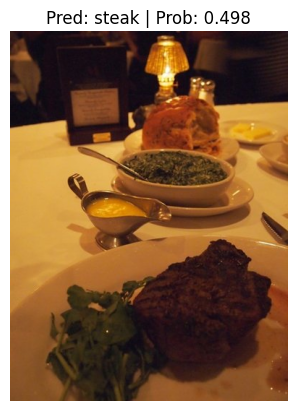

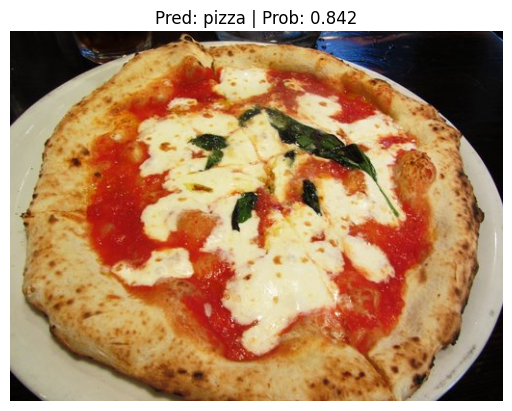

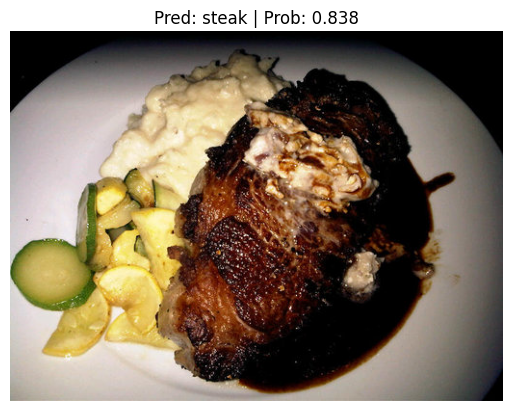

In [80]:
from going_modular.going_modular import predictions

#get a random list of 3 iamge ath names form the testdataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    predictions.pred_and_plot_image(model=best_model,
                                    image_path=image_path,
                                    class_names=class_names,
                                    image_size=(224,224),
                                    device=device)


In [109]:
#predict on a custom image with the best model
import requests
from pathlib import Path
# Setup custom image path
data_path = Path ("data")
custom_image_path = data_path / "steak1.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://i.pinimg.com/736x/01/8d/0a/018d0a029bd3442753541aa1b56870dd--minecraft-party-steaks.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


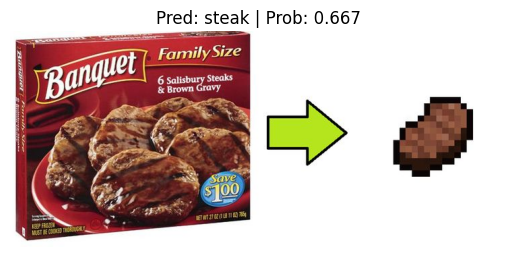

In [110]:
# Predict on custom image
predictions.pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224,224))